In [3]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
import pandas as pd
from bs4 import BeautifulSoup
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [5]:

browser = webdriver.Chrome()
browser.get("https://bwt.cbp.gov/historical")
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
list_of_df = []


Empty DataFrame
Columns: []
Index: []


In [6]:
port_element = browser.find_element(By.ID,"port")
lane_element = browser.find_element(By.ID,"lane")
sublane_element = browser.find_element(By.ID,"sublane")
month_element = browser.find_element(By.ID,"month")
port = Select(port_element)
lane = Select(lane_element)
sublane = Select(sublane_element)
month_select = Select(month_element)
for month_name in months:
    time.sleep(2)
    port.select_by_visible_text("Nogales - Morley Gate")
    lane.select_by_visible_text("Pedestrian")
    sublane.select_by_visible_text("General")
    month_select.select_by_visible_text(month_name)
    temp = "/html/body/app-root/app-historical/div/div/div/div[1]/div[1]/form/div/div/div/table/tr[5]/td[3]/button"

    button = browser.find_element(By.XPATH, temp)
    button.click()
    time.sleep(1)

    temp_table = "/html/body/app-root/app-historical/div/div/div/div[1]/ul/li[2]/a"
    table_button = browser.find_element(By.XPATH, temp_table)
    table_button.click()
    time.sleep(1)

    html_content = browser.page_source

    # Parse the HTML content with Beautiful Soup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract column headers
    headers = [th.text for th in soup.select('table thead tr th')]

    # Extract data rows
    data = []
    for row in soup.select('table tbody tr'):
        # Check if the row has any <td> elements
        if row.select('td'):
            row_data = [td.text for td in row.select('td')]
            data.append(row_data)

    # Create a pandas DataFrame
    month_df = pd.DataFrame(data, columns=headers)
    list_of_df.append(month_df)
    time.sleep(3)


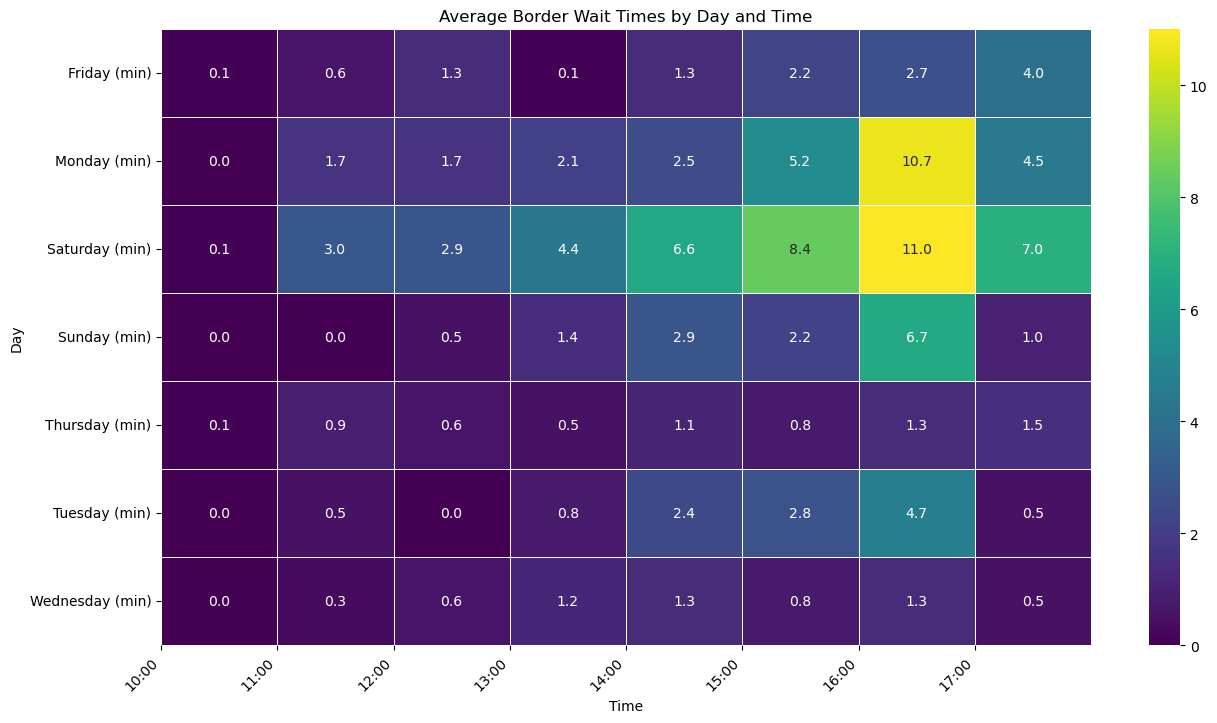

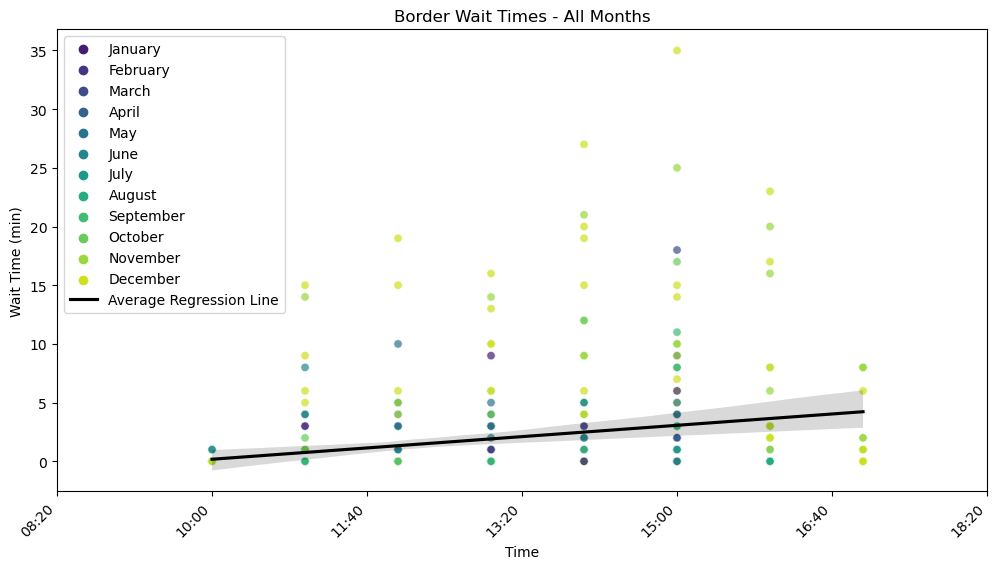

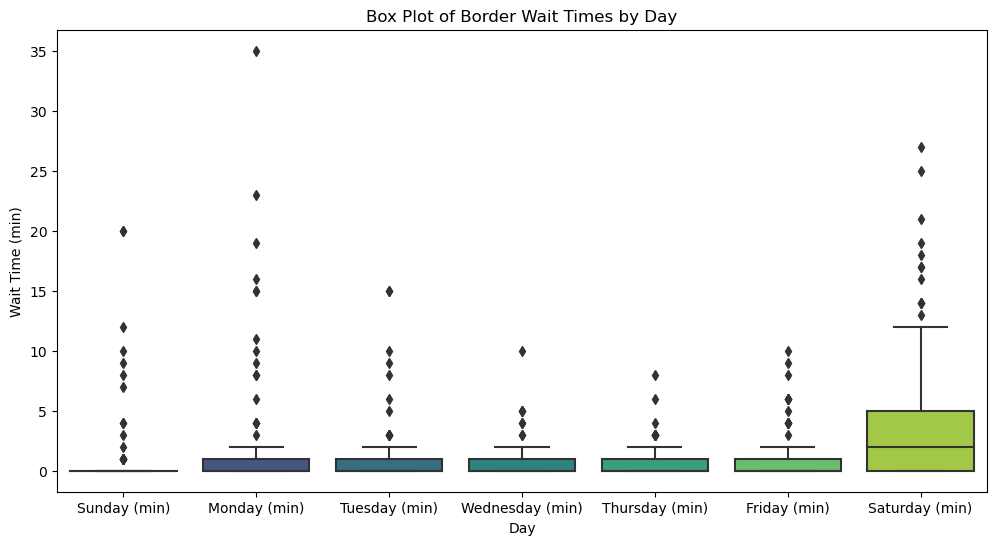

In [12]:
#merge data frames and get average
#print(list_of_df)

# Combine DataFrames into a single DataFrame with 'Month' and 'Day' columns
combined_df = pd.concat([df.assign(Month=months[i]) for i, df in enumerate(list_of_df)], ignore_index=True)

# Drop rows where 'Wait Time (min)' is empty or contains empty strings
combined_df = combined_df[combined_df['Sunday (min)'].astype(str).str.strip() != '']

# Explicitly specify id_vars and value_vars for melting
melted_df = pd.melt(
    combined_df,
    id_vars=['Time', 'Month'],
    value_vars=['Sunday (min)', 'Monday (min)', 'Tuesday (min)', 'Wednesday (min)', 'Thursday (min)', 'Friday (min)', 'Saturday (min)'],
    var_name='Day',
    value_name='Wait Time (min)'
)

# Convert 'Time' column to minutes from midnight
melted_df['Time'] = melted_df['Time'].apply(lambda x: pd.to_datetime(x, format='%I:%M %p').hour * 60 + pd.to_datetime(x, format='%I:%M %p').minute if x != 'Noon' else 12 * 60)

# Convert 'Wait Time (min)' to numeric
melted_df['Wait Time (min)'] = pd.to_numeric(melted_df['Wait Time (min)'], errors='coerce')

# Filter out rows where 'Wait Time (min)' is not empty
melted_df = melted_df[melted_df['Wait Time (min)'].notna()]

# Calculate average wait time for each time point
average_df = melted_df.groupby(['Time']).mean().reset_index()

average_heatmap_df = melted_df.groupby(['Day', 'Time']).mean().reset_index()

# Pivot the DataFrame for heatmap plotting
heatmap_data = average_heatmap_df.pivot('Day', 'Time', 'Wait Time (min)')

# Define time_values
time_values = melted_df['Time'].unique()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)

# Customize x-axis ticks to display time in 12-hour format
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))  # Set major ticks every 60 minutes

# Manually set x-axis tick positions and labels
x_positions = [i for i in range(len(time_values))]
time_labels = [f"{int(x // 60):02d}:{int(x % 60):02d}" for x in time_values]  # Convert minutes back to HH:MM format
ax.set_xticks(x_positions)
ax.set_xticklabels(time_labels, rotation=45, ha='right')

plt.title('Average Border Wait Times by Day and Time')
plt.show()
# Plot scatter plot with average regression line
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Time', y='Wait Time (min)', hue='Month', data=melted_df, palette='viridis', alpha=0.7)
sns.regplot(x=average_df['Time'], y=average_df['Wait Time (min)'], scatter=False, color='black', label='Average Regression Line')

# Customize x-axis ticks for the scatter plot
plt.xticks(rotation=45, ha='right')

# Convert 'Time' ticks to HH:MM format for better readability
time_labels_scatter = [f"{int(x // 60):02d}:{int(x % 60):02d}" for x in plt.xticks()[0]]
plt.xticks(plt.xticks()[0], time_labels_scatter)

plt.title('Border Wait Times - All Months')
plt.legend()
plt.show()

# Add the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day', y='Wait Time (min)', data=melted_df, palette='viridis')
plt.title('Box Plot of Border Wait Times by Day')
plt.xlabel('Day')
plt.ylabel('Wait Time (min)')

plt.show()
